In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time as tm


import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from copy import deepcopy

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from PyAstronomy.modelSuite import forTrans as ft
from PyAstronomy.pyasl import isInTransit

from lightkurve import KeplerLightCurveFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import median_boxcar_filter, bindata, transit_duration, flag_outliers, fit_eclipse_bottom
from variable_eclipses_utils import retreive_data

KIC = 4570949

In [14]:
# The system parameters as reported in Faigler et al. (2013) --
#  http://iopscience.iop.org/article/10.1088/0004-637X/771/1/26/meta
a = 1./0.221 #± 0.003
b = 0.944 # ± 0.011
inc = 78.0 # ± 0.2
per = 1.54492875*u.day # ± 0.00000027
Kz_m_per_s = 308. # ± 20.
Kz = convert_Kz(Kz=Kz_m_per_s) # convert to fraction of the speed of light

Mp = 2.00*u.jupiterMass # ± 0.26
Rp_over_a = 0.0214 # ± 0.0008
Rp_over_Rs = Rp_over_a*a
Ms = 1.2*u.solMass # ± 0.2
q = (Mp.to('kg')/Ms.to('kg')).value

vsini = 6500.*u.m/u.s # ± 2000
Rs = 1.32*u.solRad #± 0.08
Omegas = vsini.to('m/s')/Rs.to('m')*per.to('s') # stellar rotation state - very little effect, so chosen arbitrarily

Ts = 6300. # ± 200
Faigler_T0 = (737.49 + 2455000. - 2454833.)# % per.to('day').value # ±0.19
T0 = 0.68508434

coeffs = [0.313, 0.304]

Aplanet = 60.4e-6 # ± 2.0
F0 = 60.4e-6 # ± 2.0 -- overall shift in light curve, which is arbitrary
phase_shift = -10.3/360. # ± 2.0 - convert phase shift angle from degrees to orbital phase

beta = 0.0716671 # Interpolation from among the values reported in Claret & Bloemen (2011) A&A 529, 75

# Save parameters to an evilmc parameters object
saved_ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, limb_dark="quadratic", b=b, 
                    F0=F0, Aplanet=Aplanet, phase_shift=phase_shift, beta=beta, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], 
                    u=coeffs)

In [3]:
# 2018 Sep 5 - As a way of minimizing compute time while maximizing the eclipse signal, 
#   I'll take a binsize of 30-min and a boxcar window size equal to one orbital period.
num_period = 1
binsize = 30./60./24.
    
# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(saved_ep.per, num_periods=num_period, 
                                                         KIC=KIC, fit_bottom=True, params=saved_ep, drop_outliers=True)
folded_time = filtered_time % saved_ep.per

# Estimate scatter
dur = transit_duration(saved_ep)
ind = ~(np.abs(folded_time - saved_ep.T0) < dur)
unbinned_noise = mad(filtered_flux[ind])
print(unbinned_noise*1e6)

141.83679022846897


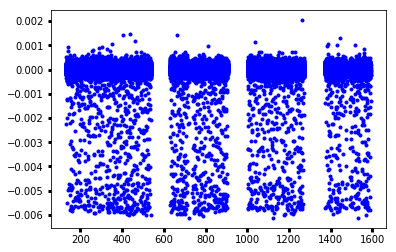

In [18]:
# Initial fit using Faigler's parameters (with my own T0)
plt.plot(filtered_time, filtered_flux, 'b.')

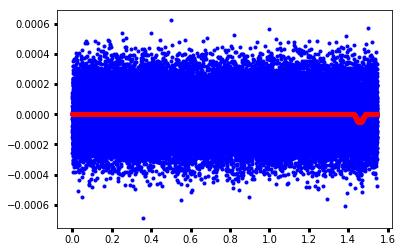

In [9]:
def fit_eclipse(time, cur_eclipse_depth, supersample_factor=100, exp_time=30./60./24.):
    cur_ep = evparams(per=saved_ep.per, a=saved_ep.a, T0=saved_ep.T0, p=saved_ep.p, limb_dark="quadratic", 
                      b=saved_ep.b, beta=saved_ep.beta, Ts=Ts, Ws=[0.,0., Omegas], u=saved_ep.u,
                      q=saved_ep.q, Kz=saved_ep.Kz, F0=saved_ep.F0, Aplanet=saved_ep.Aplanet, 
                      phase_shift=saved_ep.phase_shift)

    em = evmodel(time, cur_ep, supersample_factor=supersample_factor, exp_time=exp_time)
    
    return em.calc_eclipse(cur_eclipse_depth)

# Let's start with just fitting one eclipse with just white noise with about the same scatter as the real data.
eclipse_depth = 50e-6

synthetic_eclipse = fit_eclipse(filtered_time, eclipse_depth)
noisy_synthetic_eclipse = synthetic_eclipse + normal(size=len(synthetic_eclipse), scale=unbinned_noise)

plt.plot(folded_time, noisy_synthetic_eclipse, 'b.')
plt.plot(folded_time, synthetic_eclipse, 'r.')

5e-05
[5.94881832e-05]
[2.09160313]


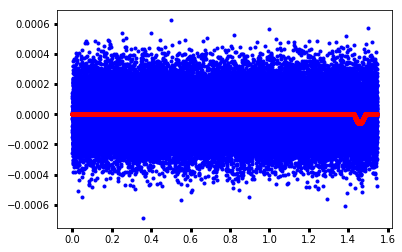

In [10]:
time = folded_time
data = noisy_synthetic_eclipse

initial_guess = [0.]
eclipse_popt, eclipse_pcov = curve_fit(fit_eclipse, time, data, sigma=unbinned_noise*np.ones_like(time),
                                       p0=initial_guess, 
                                       bounds=(-1000e-6, 1000e-6))
print(eclipse_depth)
print(eclipse_popt)
print(np.abs(eclipse_popt[0] - eclipse_depth)/np.sqrt(eclipse_pcov.diagonal()))

plt.plot(time, data, 'b.')
plt.plot(time, fit_eclipse(time, *eclipse_popt), 'r.')

(1.4, 1.5)

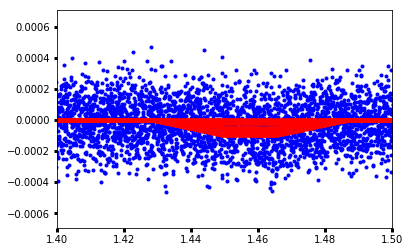

In [85]:
# Now I'd like to make the eclipse depth vary sinusoidally from orbit to orbit, stack the eclipses all together,
# and see what eclipse depth I get.
which_orbit = np.floor((filtered_time - Faigler_T0)/saved_ep.per)
which_orbit -= np.min(which_orbit)
which_orbit_unq = np.unique(which_orbit)
which_orbit_midtime = which_orbit_unq*saved_ep.per

eclipse_variability_period = 10.*saved_ep.per # eclipse depth will vary with a period equal to 10 orbits
eclipse_variability_amplitude = eclipse_depth
eclipse_depths = eclipse_variability_amplitude*(1. + np.sin(2.*np.pi/eclipse_variability_period*which_orbit_midtime))

synthetic_eclipses = np.zeros_like(filtered_time)
noisy_synthetic_eclipses = np.zeros_like(filtered_time)
for i in range(len(which_orbit_unq)-1):
    mn = which_orbit_unq[i]*saved_ep.per + np.min(filtered_time)
    mx = (which_orbit_unq[i] + 1)*saved_ep.per + np.min(filtered_time)
    
    ind = (filtered_time >= mn) & (filtered_time < mx)
    synthetic_eclipses[ind] = fit_eclipse(filtered_time[ind], eclipse_depths[i])
    noisy_synthetic_eclipses[ind] = synthetic_eclipses[ind] +\
        normal(size=len(synthetic_eclipses[ind]), scale=unbinned_noise)
    
plt.plot(folded_time, noisy_synthetic_eclipses, 'b.')
plt.plot(folded_time, synthetic_eclipses, 'r.')
plt.xlim([1.4, 1.5])

(5e-05, 4.9829692319775456e-05)
[5.94881832e-05]
[2.09160313]


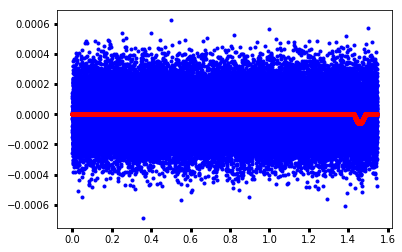

In [86]:
time = folded_time
data = noisy_synthetic_eclipse

initial_guess = [0.]
eclipse_popt, eclipse_pcov = curve_fit(fit_eclipse, time, data, sigma=unbinned_noise*np.ones_like(time),
                                       p0=initial_guess, 
                                       bounds=(-1000e-6, 1000e-6))
print(eclipse_variability_amplitude, np.mean(eclipse_depths))
print(eclipse_popt)
print(np.abs(eclipse_popt[0] - eclipse_depth)/np.sqrt(eclipse_pcov.diagonal()))

plt.plot(time, data, 'b.')
plt.plot(time, fit_eclipse(time, *eclipse_popt), 'r.')

# 2018 Sep 19 -
# (5e-05, 4.9829692319775456e-05)
# [5.94881832e-05]
# [2.09160313]
#
# Able to recover the average!